# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
! pip install --upgrade pip
! pip install pandas
! pip install seaborn
! pip install matplotlib


In [31]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# EXPLORE AND CLEAN PORTFOLIO DATAFRAME

In [32]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [33]:
portfolio.shape

(10, 6)

In [34]:
portfolio_df = portfolio.copy()

* Create a new column called offer which assigns numbers 1 - 10 for each type of offer. This will be used as offer_id in the final table for readability.
* Extract each channel from the list of channels
* Use MultiLabelBinarizer to one hot encode list of channels.
* Create a column with duration by hour.
* Reorganize all columns.

In [35]:
portfolio_df['offer'] = portfolio.index + 1

In [36]:
from sklearn.preprocessing import MultiLabelBinarizer

# create an instance of the MultiLabelBinarizer class
mlb = MultiLabelBinarizer()

# fit and transform the column of lists into a binary matrix
encoded = mlb.fit_transform(portfolio_df['channels'])

# create a new DataFrame with the binary matrix
df_encoded = pd.DataFrame(encoded, columns=mlb.classes_)

# concatenate the new DataFrame with the original DataFrame
portfolio_df = pd.concat([portfolio_df, df_encoded], axis=1)

In [37]:
portfolio_df = portfolio_df[["id", "offer", "offer_type", "difficulty", "duration", "reward", "channels", "web", "email", "social", "mobile"]]

In [38]:
portfolio_df['duration_hr'] = portfolio_df['duration'] * 24

In [39]:
portfolio_df

,id,offer,offer_type,difficulty,duration,reward,channels,web,email,social,mobile,duration_hr
0,ae264e3637204a6fb9bb56bc8210ddfd,1,bogo,10,7,10,"[email, mobile, social]",0,1,1,1,168
1,4d5c57ea9a6940dd891ad53e9dbe8da0,2,bogo,10,5,10,"[web, email, mobile, social]",1,1,1,1,120
2,3f207df678b143eea3cee63160fa8bed,3,informational,0,4,0,"[web, email, mobile]",1,1,0,1,96
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,bogo,5,7,5,"[web, email, mobile]",1,1,0,1,168
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,discount,20,10,5,"[web, email]",1,1,0,0,240
5,2298d6c36e964ae4a3e7e9706d1fb8c2,6,discount,7,7,3,"[web, email, mobile, social]",1,1,1,1,168
6,fafdcd668e3743c1bb461111dcafc2a4,7,discount,10,10,2,"[web, email, mobile, social]",1,1,1,1,240
7,5a8bc65990b245e5a138643cd4eb9837,8,informational,0,3,0,"[email, mobile, social]",0,1,1,1,72
8,f19421c1d4aa40978ebb69ca19b0e20d,9,bogo,5,5,5,"[web, email, mobile, social]",1,1,1,1,120
9,2906b810c7d4411798c6938adc9daaa5,10,discount,10,7,2,"[web, email, mobile]",1,1,0,1,168


In [40]:
# portfolio_df.to_csv('data/portfolio_df.csv', index = False)

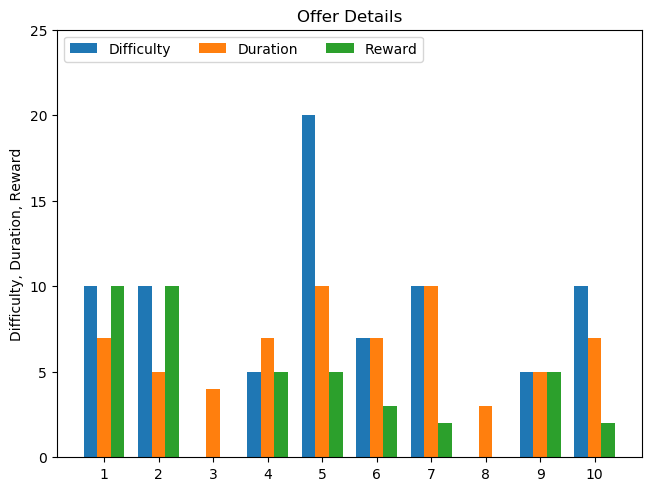

In [41]:
offers = tuple(list(portfolio_df.offer))
offer_details = {
    'Difficulty': list(portfolio['difficulty']),
    'Duration': list(portfolio['duration']),
    'Reward': list(portfolio['reward']),
}
x_labels = offers

x = np.arange(len(offers))  
width = 0.25  
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in offer_details.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
    

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difficulty, Duration, Reward')
ax.set_title('Offer Details')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left', ncol=3)
ax.set_ylim(0, 25)

plt.show()

# plt.savefig(os.path.join('photos/diff_duration_reward.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

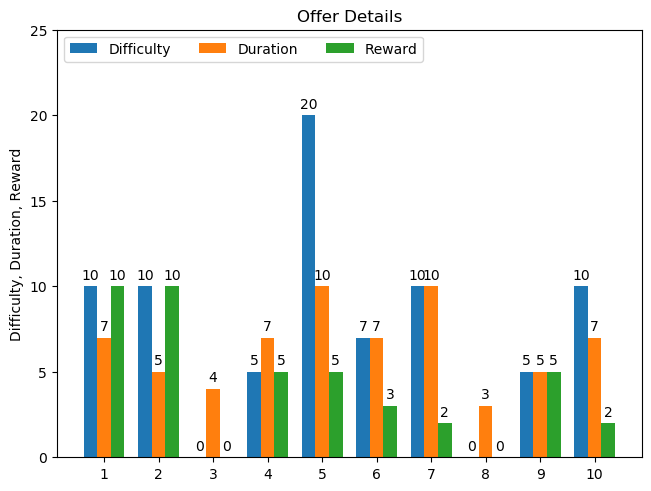

In [383]:
offers = tuple(list(portfolio_df.offer))
offer_details = {
    'Difficulty': list(portfolio['difficulty']),
    'Duration': list(portfolio['duration']),
    'Reward': list(portfolio['reward']),
}
x_labels = offers

x = np.arange(len(offers))  
width = 0.25
multiplier = 0

fig, ax = plt.subplots(constrained_layout=True)

for attribute, measurement in offer_details.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
    
    # Add value annotations
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Difficulty, Duration, Reward')
ax.set_title('Offer Details')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
ax.legend(loc='upper left', ncol=3)
ax.set_ylim(0, 25)

plt.show()


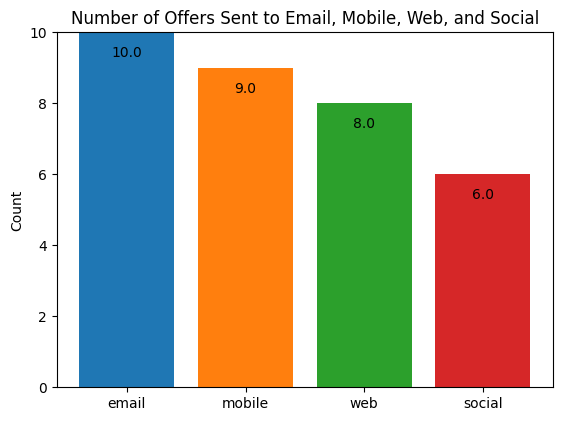

In [14]:
# create sample data
data = {
    'email': list(portfolio_df['email']),
    'mobile': list(portfolio_df['mobile']),
    'web': list(portfolio_df['web']),
    'social': list(portfolio_df['social'])
}

df = pd.DataFrame(data)


value_counts = df.apply(pd.Series.value_counts)

x_labels = value_counts.columns
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
rects = ax.bar(x, value_counts.loc[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for i, rect in enumerate(rects):
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, -20),  
                textcoords="offset points",
                ha='center', va='bottom')


ax.set_ylabel('Count')
ax.set_title('Number of Offers Sent to Email, Mobile, Web, and Social')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylim(0, len(df))

plt.subplots_adjust(top=0.85)

plt.show()

# plt.savefig(os.path.join('photos/offer_channels.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

# Exploration and Cleaning of Profile Dataframe

In [42]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [43]:
profile.shape

(17000, 5)

In [44]:
len(profile.id.unique())

17000

In [45]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [46]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


* Remove NA values.
* Remove ages that are equal to 118.
* Find the membership duration in days using the difference between the maximum 'became member on' date and the actual 'became member on' date
* Rearrange the columns.
* Save the new table to csv


In [47]:
profile_df = profile.dropna()

In [48]:
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'].astype(str), format='%Y%m%d')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
print(min(profile_df['became_member_on']))
print(max(profile_df['became_member_on']))

2013-07-29 00:00:00
2018-07-26 00:00:00


In [50]:
profile_df['membership_duration'] = round((max(profile_df['became_member_on']) - profile_df["became_member_on"]).dt.days) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
profile_df = profile_df[["id", "age", "gender", "income", "became_member_on", "membership_duration"]]

In [52]:
profile_df.head()

,id,age,gender,income,became_member_on,membership_duration
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443
5,e2127556f4f64592b11af22de27a7932,68,M,70000.0,2018-04-26,91
8,389bc3fa690240e798340f5a15918d5c,65,M,53000.0,2018-02-09,167
12,2eeac8d8feae4a8cad5a6af0499a211d,58,M,51000.0,2017-11-11,257


In [288]:
# profile_df.to_csv('profile_df.csv', index = False)

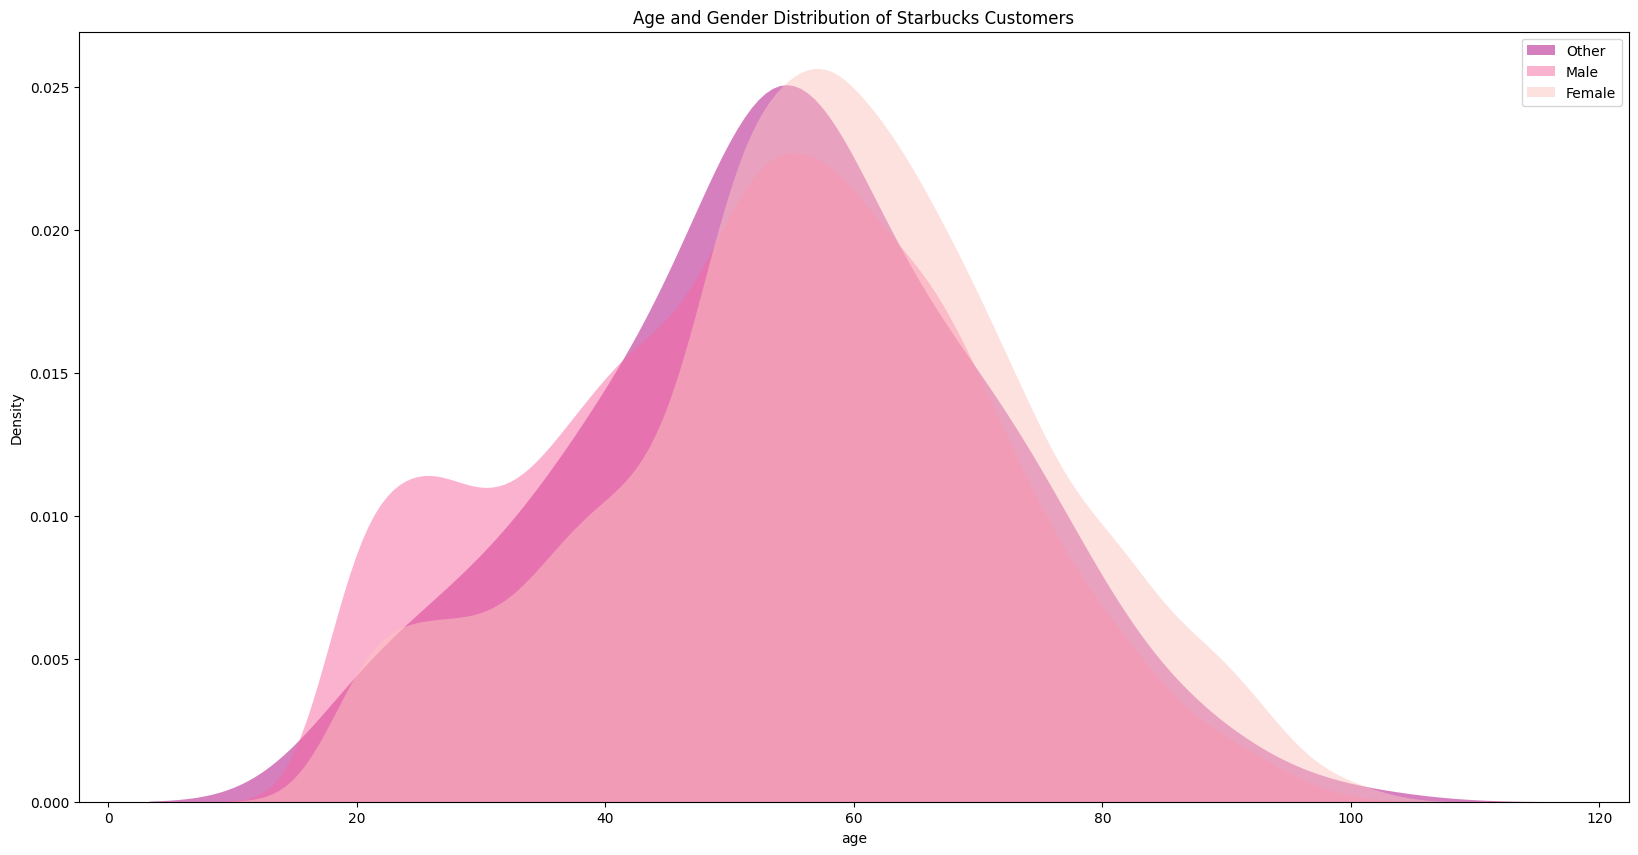

In [27]:
plt.figure(figsize=(20,10))
sns.kdeplot(
    data=profile_df, 
    x="age", 
    hue="gender",
    fill=True, 
    common_norm=False, 
    palette="RdPu",
    alpha=.5, 
    linewidth=0,
)
plt.legend(labels=['Other', 'Male', 'Female'])
plt.title('Age and Gender Distribution of Starbucks Customers')
plt.show()

# plt.savefig(os.path.join('photos/age_gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

<Axes: title={'center': 'Gender of Starbucks Customers'}, ylabel='gender'>

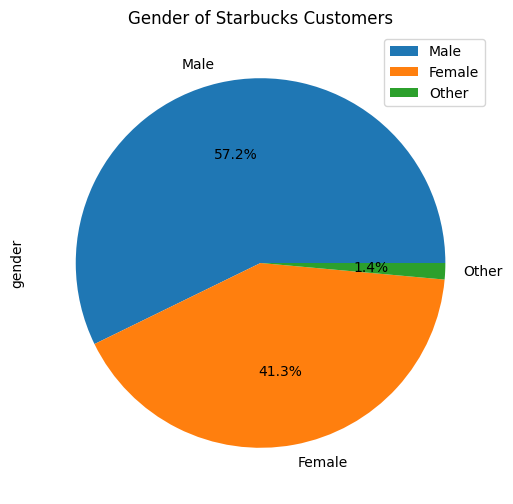

In [28]:
profile_df['gender'].value_counts().plot.pie(legend = True, 
                                             labels = ['Male', 'Female', 'Other'], 
                                             figsize=(11, 6),
                                             title = 'Gender of Starbucks Customers',
                                             autopct='%1.1f%%'
                                            )

# plt.savefig(os.path.join('photos/gender.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

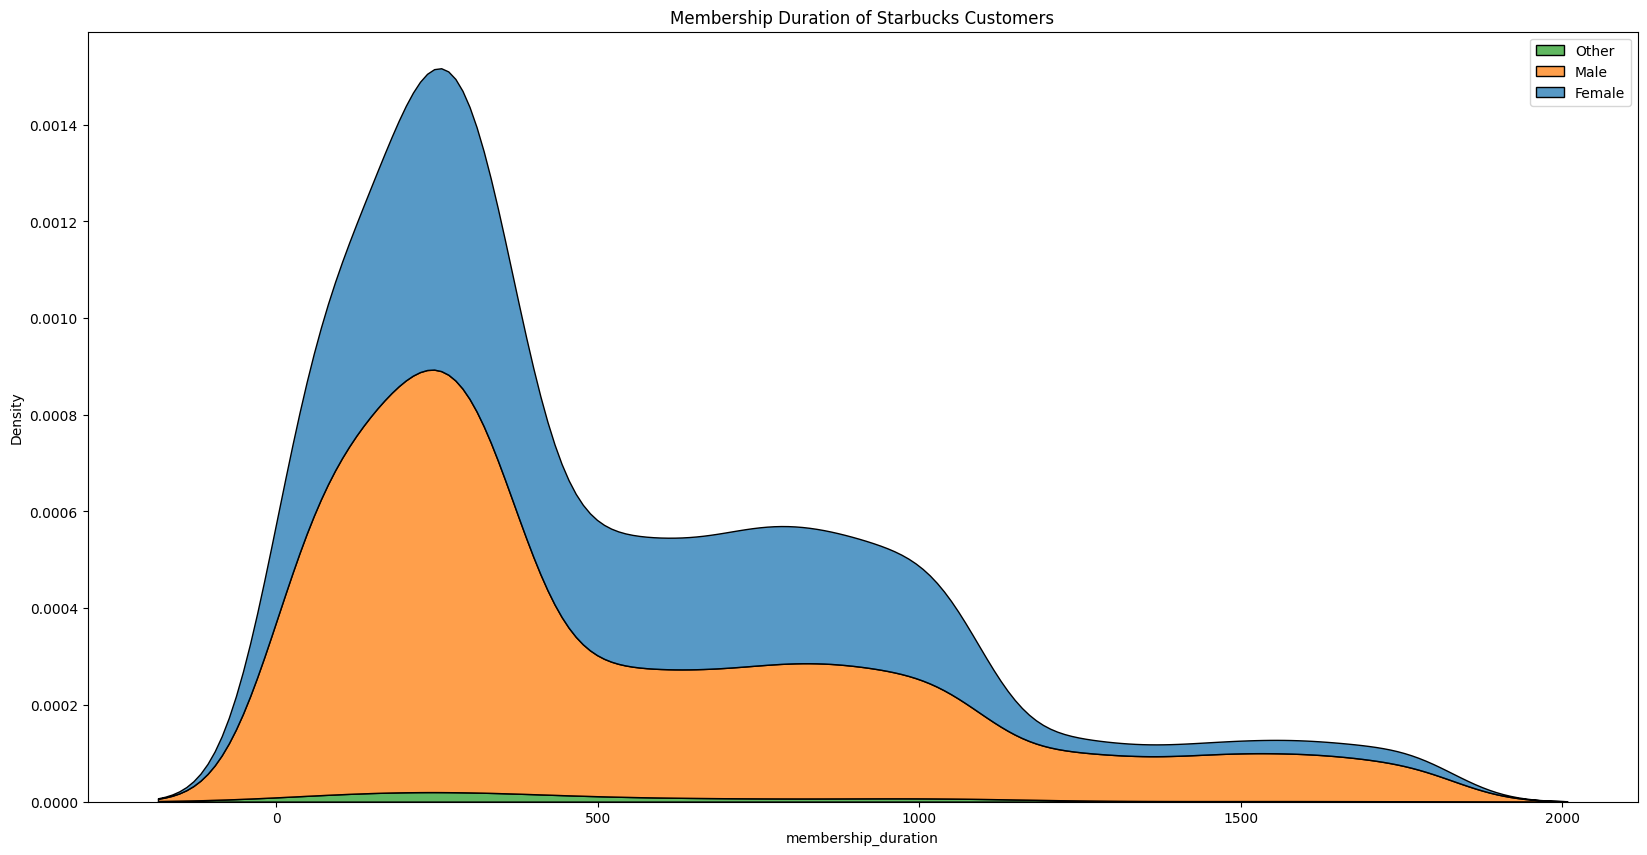

In [29]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=profile_df, 
            x="membership_duration", 
            hue="gender", 
            multiple="stack")
plt.legend(labels = ['Other', 'Male', 'Female'])
plt.title('Membership Duration of Starbucks Customers')
plt.show()

# plt.savefig(os.path.join('photos/membership_duration.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

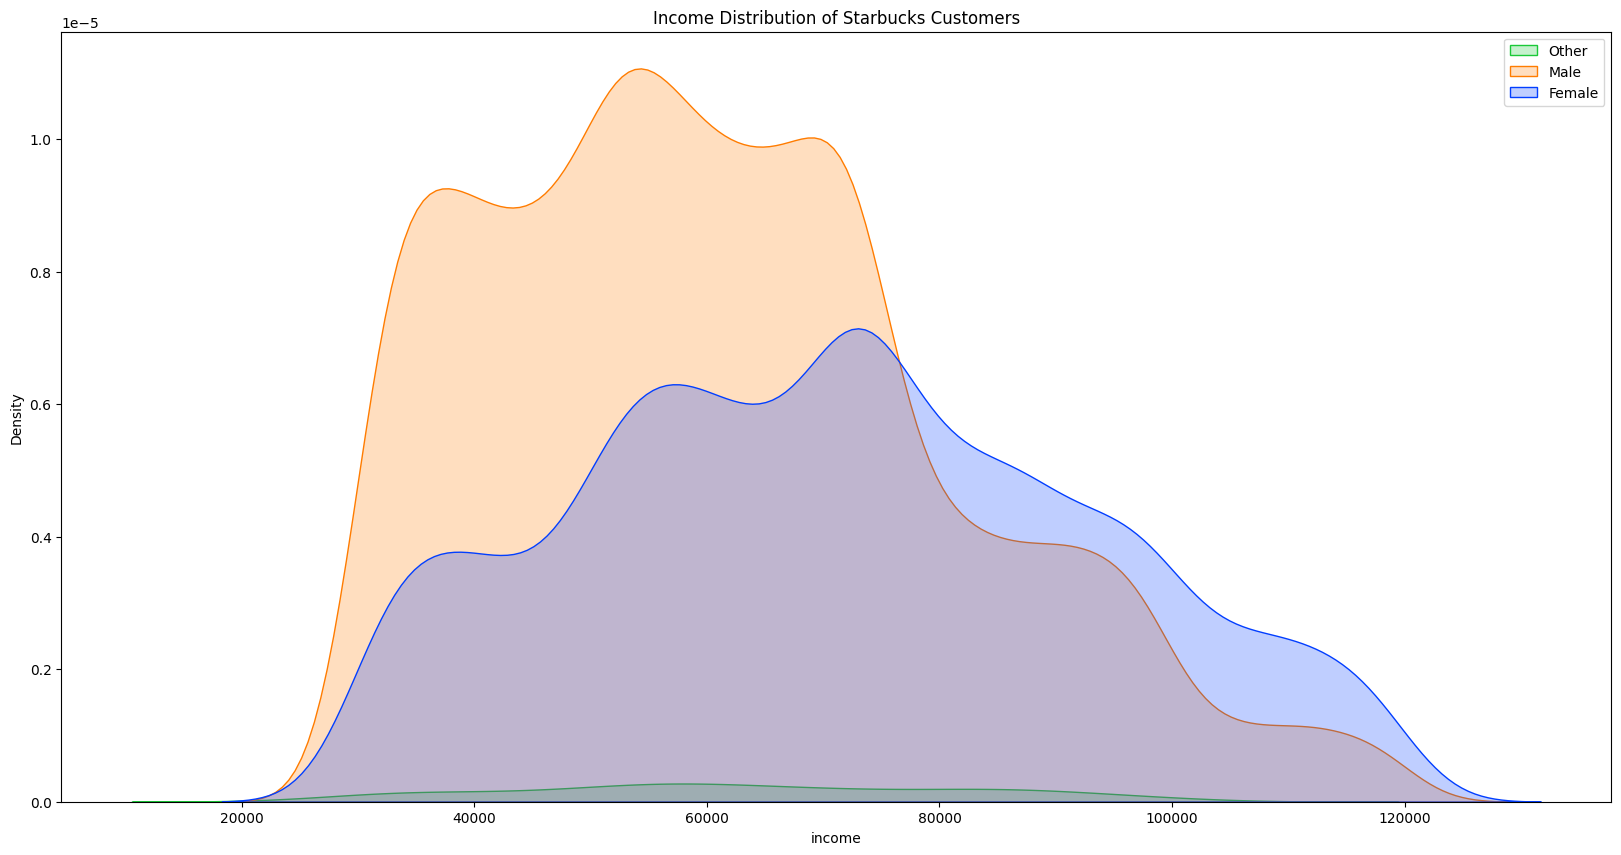

In [30]:
plt.figure(figsize=(20,10))
sns.kdeplot(
    data=profile_df, 
    x="income", 
    hue="gender",
    fill = True,
    palette="bright"
)
plt.legend(labels=['Other', 'Male', 'Female'])
plt.title('Income Distribution of Starbucks Customers')
plt.show()

# plt.savefig(os.path.join('photos/income_distribution.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

# Transcript Dataframe

In [53]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [54]:
len(transcript['person'].unique())

17000

In [55]:
len(profile_df['id'].unique())

14825

In [56]:
len(profile['id'].unique())

17000

In [57]:
transcript.shape

(306534, 4)

In [58]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

* Split transaction into 4 dataframes: transaction_df, offer_received_df, offer_viewed, offer_completed
* Extract the value elements from the dictionary and create a new column for each.

In [59]:
transcript_df = transcript.copy()

In [60]:
transcript_profile = pd.merge(
    profile_df,
    transcript_df,
    how = "left",
    left_on = "id",
    right_on = "person"
)

In [61]:
transcript_profile.shape

(272762, 10)

In [62]:
transcript_profile.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
value                  0
time                   0
dtype: int64

## Transaction & Profile

In [63]:
transcript_profile[transcript_profile.event == 'transaction'].head()

,id,age,gender,income,became_member_on,membership_duration,person,event,value,time
0,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144
4,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528
8,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
10,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144


In [64]:
transaction_df = transcript_profile[transcript_profile.event == 'transaction']
transaction_df.shape

(123957, 10)

In [65]:
transcript_profile.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
value                  0
time                   0
dtype: int64

In [66]:
transaction_df['amount_spent'] = transaction_df['value'].apply(lambda x: x['amount'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
transaction_df.head()

,id,age,gender,income,became_member_on,membership_duration,person,event,value,time,amount_spent
0,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 21.51},18,21.51
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 32.28},144,32.28
4,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,{'amount': 23.22},528,23.22
8,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,19.89
10,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,17.78


In [68]:
transaction_df = transaction_df.drop('value', axis = 1)

In [69]:
transaction_df.drop_duplicates()

,id,age,gender,income,became_member_on,membership_duration,person,event,time,amount_spent
0,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,18,21.51
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,144,32.28
4,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,transaction,528,23.22
8,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89
10,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78
...,...,...,...,...,...,...,...,...,...,...
272752,e4052622e5ba45a8b96b59aba68cf068,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,transaction,84,25.19
272753,e4052622e5ba45a8b96b59aba68cf068,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,transaction,96,21.53
272756,e4052622e5ba45a8b96b59aba68cf068,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,transaction,480,30.57
272758,e4052622e5ba45a8b96b59aba68cf068,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,transaction,486,19.47


In [70]:
transaction_df.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
time                   0
amount_spent           0
dtype: int64

In [71]:
transaction_df = transaction_df.dropna()

In [72]:
transaction_df.shape

(123957, 10)

In [73]:
# transaction_df.to_csv('data/transaction.csv', index = False)

## Offer Received, Viewed, Completed

In [74]:
offer_received_df = transcript_profile[transcript_profile.event == 'offer received']
offer_viewed_df = transcript_profile[transcript_profile.event == 'offer viewed']
offer_completed_df = transcript_profile[transcript_profile.event == 'offer completed']

In [75]:
print(offer_received_df.shape)
print(offer_viewed_df.shape)
print(offer_completed_df.shape)

(66501, 10)
(49860, 10)
(32444, 10)


In [76]:
offer_received_df.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
value                  0
time                   0
dtype: int64

In [77]:
offer_received_df['offer_id'] = offer_received_df['value'].apply(lambda x: x['offer id'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
offer_received_df.head()

,id,age,gender,income,became_member_on,membership_duration,person,event,value,time,offer_id
2,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,3f207df678b143eea3cee63160fa8bed
6,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
11,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837
16,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,ae264e3637204a6fb9bb56bc8210ddfd


In [79]:
offer_viewed_df['offer_id'] = offer_viewed_df['value'].apply(lambda x: x['offer id'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
offer_viewed_df.head()

,id,age,gender,income,became_member_on,membership_duration,person,event,value,time,offer_id
7,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,9b98b8c7a33c4b65b9aebfe6a799e6d9
12,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,5a8bc65990b245e5a138643cd4eb9837
17,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,ae264e3637204a6fb9bb56bc8210ddfd
23,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},582,f19421c1d4aa40978ebb69ca19b0e20d
25,e2127556f4f64592b11af22de27a7932,68,M,70000.0,2018-04-26,91,e2127556f4f64592b11af22de27a7932,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},18,2906b810c7d4411798c6938adc9daaa5


In [81]:
offer_completed_df['offer_id'] = offer_completed_df['value'].apply(lambda x: x['offer_id'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
offer_completed_df.head()

,id,age,gender,income,became_member_on,membership_duration,person,event,value,time,offer_id
5,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,528,9b98b8c7a33c4b65b9aebfe6a799e6d9
9,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,9b98b8c7a33c4b65b9aebfe6a799e6d9
20,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,510,ae264e3637204a6fb9bb56bc8210ddfd
21,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,510,f19421c1d4aa40978ebb69ca19b0e20d
34,e2127556f4f64592b11af22de27a7932,68,M,70000.0,2018-04-26,91,e2127556f4f64592b11af22de27a7932,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,522,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [83]:
offer_received_df.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
value                  0
time                   0
offer_id               0
dtype: int64

In [84]:
merged_received = offer_received_df.copy()

In [85]:
merged_received.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
value                  0
time                   0
offer_id               0
dtype: int64

In [86]:
merged_viewed = offer_viewed_df.copy()

In [87]:
merged_viewed.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
value                  0
time                   0
offer_id               0
dtype: int64

In [92]:
received_viewed_completed = pd.merge(
    merged_received,
    merged_viewed,
    how = "outer",
    on = ["person", "offer_id", "age", "gender", "income", "became_member_on", "membership_duration"]
)

In [93]:
received_viewed_completed.shape

(82834, 15)

In [94]:
received_viewed_completed.isna().sum()

id_x                       0
age                        0
gender                     0
income                     0
became_member_on           0
membership_duration        0
person                     0
event_x                    0
value_x                    0
time_x                     0
offer_id                   0
id_y                   14403
event_y                14403
value_y                14403
time_y                 14403
dtype: int64

In [95]:
received_viewed_completed = received_viewed_completed.drop(['id_x', 'id_y'], axis = 1)

In [96]:
received_viewed_completed['event_y'].isna().sum()

14403

In [103]:
merged_completed = offer_completed_df.copy()

In [104]:
merged_completed.isna().sum()

id                     0
age                    0
gender                 0
income                 0
became_member_on       0
membership_duration    0
person                 0
event                  0
value                  0
time                   0
offer_id               0
dtype: int64

In [106]:
received_viewed_completed = pd.merge(
    received_viewed_completed,
    merged_completed,
    how = 'left',
    on = ["person", "offer_id", "age", "gender", "income", "became_member_on", "membership_duration"]
)

In [107]:
received_viewed_completed.shape

(102693, 17)

In [108]:
received_viewed_completed.head()

,age,gender,income,became_member_on,membership_duration,person,event_x,value_x,time_x,offer_id,event_y,value_y,time_y,id,event,value,time
0,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,0610b486422d4921ae7d2bf64640c50b,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,528.0
1,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6.0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132.0
3,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216.0,NaN,NaN,NaN,NaN
4,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408,ae264e3637204a6fb9bb56bc8210ddfd,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},408.0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,510.0


In [109]:
received_viewed_completed.isna().sum()

age                        0
gender                     0
income                     0
became_member_on           0
membership_duration        0
person                     0
event_x                    0
value_x                    0
time_x                     0
offer_id                   0
event_y                15081
value_y                15081
time_y                 15081
id                     37701
event                  37701
value                  37701
time                   37701
dtype: int64

In [ ]:
# received_viewed_completed = received_viewed_completed.drop(['id', 'age', 'gender', 'income', 'became_member_on', 'membership_duration'], axis = 1)

In [110]:
recieved_viewed_completed = received_viewed_completed.rename(columns={'event_x': 'offer_received', 'time_x': 'time_received', 'event_y': 'offer_viewed', 'time_y': 'time_viewed', 'event': 'offer_completed', 'time': 'time_completed'}, inplace = True)

In [661]:
# recieved_viewed_completed = received_viewed_completed.rename(columns={'age_x': 'age', 'gender_x': 'gender', 'income_x': 'income', 'became_member_on_x': 'became_member_on', 'membership_duration_x': 'membership_duration'}, inplace = True)

In [111]:
received_viewed_completed.isna().sum()

age                        0
gender                     0
income                     0
became_member_on           0
membership_duration        0
person                     0
offer_received             0
value_x                    0
time_received              0
offer_id                   0
offer_viewed           15081
value_y                15081
time_viewed            15081
id                     37701
offer_completed        37701
value                  37701
time_completed         37701
dtype: int64

In [112]:
received_viewed_completed['offer_viewed'] = received_viewed_completed['offer_viewed'].fillna(0)

In [113]:
received_viewed_completed.loc[received_viewed_completed['offer_viewed'] == 'offer viewed', 'offer_viewed'] = 1

In [114]:
received_viewed_completed['offer_viewed'].value_counts()

1    87612
0    15081
Name: offer_viewed, dtype: int64

In [115]:
received_viewed_completed['offer_completed'] = received_viewed_completed['offer_completed'].fillna(0)

In [116]:
received_viewed_completed.loc[received_viewed_completed['offer_completed'] == 'offer completed', 'offer_completed'] = 1

In [117]:
received_viewed_completed['offer_completed'].value_counts()

1    64992
0    37701
Name: offer_completed, dtype: int64

In [118]:
received_viewed_completed.loc[received_viewed_completed['offer_received'] == 'offer received', 'offer_received'] = 1

In [119]:
received_viewed_completed.isna().sum()

age                        0
gender                     0
income                     0
became_member_on           0
membership_duration        0
person                     0
offer_received             0
value_x                    0
time_received              0
offer_id                   0
offer_viewed               0
value_y                15081
time_viewed            15081
id                     37701
offer_completed            0
value                  37701
time_completed         37701
dtype: int64

In [120]:
received_viewed_completed['time_viewed'] = received_viewed_completed['time_viewed'].fillna(0)

In [121]:
received_viewed_completed['time_completed'] = received_viewed_completed['time_completed'].fillna(0)

In [122]:
received_viewed_completed['reward_received'] = received_viewed_completed[received_viewed_completed.offer_completed == 1]['value'].apply(lambda x: x['reward'])

In [123]:
received_viewed_completed['reward_received'] = received_viewed_completed['reward_received'].fillna(0)

In [124]:
received_viewed_completed = received_viewed_completed.drop(['value_x', 'value_y', 'value'], axis = 1)

In [125]:
received_viewed_completed.isna().sum()

age                        0
gender                     0
income                     0
became_member_on           0
membership_duration        0
person                     0
offer_received             0
time_received              0
offer_id                   0
offer_viewed               0
time_viewed                0
id                     37701
offer_completed            0
time_completed             0
reward_received            0
dtype: int64

In [126]:
received_viewed_completed.shape

(102693, 15)

In [127]:
received_viewed_completed['offer_received'].value_counts()

1    102693
Name: offer_received, dtype: int64

In [128]:
received_viewed_completed['offer_viewed'].value_counts()

1    87612
0    15081
Name: offer_viewed, dtype: int64

In [129]:
received_viewed_completed

,age,gender,income,became_member_on,membership_duration,person,offer_received,time_received,offer_id,offer_viewed,time_viewed,id,offer_completed,time_completed,reward_received
0,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0,0610b486422d4921ae7d2bf64640c50b,1,528.0,5.0
1,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,504,3f207df678b143eea3cee63160fa8bed,0,0.0,NaN,0,0.0,0.0
2,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,6.0,78afa995795e4d85b5d9ceeca43f5fef,1,132.0,5.0
3,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,168,5a8bc65990b245e5a138643cd4eb9837,1,216.0,NaN,0,0.0,0.0
4,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,408,ae264e3637204a6fb9bb56bc8210ddfd,1,408.0,78afa995795e4d85b5d9ceeca43f5fef,1,510.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102688,83,F,50000.0,2016-03-07,871,9dc1421481194dcd9400aec7c9ae6366,1,576,ae264e3637204a6fb9bb56bc8210ddfd,1,624.0,9dc1421481194dcd9400aec7c9ae6366,1,594.0,10.0
102689,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,6.0,e4052622e5ba45a8b96b59aba68cf068,1,54.0,3.0
102690,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,1,336,3f207df678b143eea3cee63160fa8bed,0,0.0,NaN,0,0.0,0.0
102691,62,F,82000.0,2017-07-22,369,e4052622e5ba45a8b96b59aba68cf068,1,576,3f207df678b143eea3cee63160fa8bed,0,0.0,NaN,0,0.0,0.0


In [130]:
complete_df = pd.merge(
    received_viewed_completed,
    portfolio_df,
    how = "left",
    left_on = 'offer_id',
    right_on = 'id'
)

In [131]:
complete_df.shape

(102693, 27)

In [132]:
complete_df.head()

,age,gender,income,became_member_on,membership_duration,person,offer_received,time_received,offer_id,offer_viewed,...,offer_type,difficulty,duration,reward,channels,web,email,social,mobile,duration_hr
0,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,...,bogo,5,7,5,"[web, email, mobile]",1,1,0,1,168
1,55,F,112000.0,2017-07-15,376,0610b486422d4921ae7d2bf64640c50b,1,504,3f207df678b143eea3cee63160fa8bed,0,...,informational,0,4,0,"[web, email, mobile]",1,1,0,1,96
2,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,...,bogo,5,7,5,"[web, email, mobile]",1,1,0,1,168
3,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,168,5a8bc65990b245e5a138643cd4eb9837,1,...,informational,0,3,0,"[email, mobile, social]",0,1,1,1,72
4,75,F,100000.0,2017-05-09,443,78afa995795e4d85b5d9ceeca43f5fef,1,408,ae264e3637204a6fb9bb56bc8210ddfd,1,...,bogo,10,7,10,"[email, mobile, social]",0,1,1,1,168


In [688]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102693 entries, 0 to 102692
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   age                  102693 non-null  int64         
 1   gender               102693 non-null  object        
 2   income               102693 non-null  float64       
 3   became_member_on     102693 non-null  datetime64[ns]
 4   membership_duration  102693 non-null  int64         
 5   person               102693 non-null  object        
 6   offer_received       102693 non-null  object        
 7   time_received        102693 non-null  int64         
 8   offer_id             102693 non-null  object        
 9   offer_viewed         102693 non-null  object        
 10  time_viewed          102693 non-null  float64       
 11  offer_completed      102693 non-null  object        
 12  time_completed       102693 non-null  float64       
 13  reward_receive

In [ ]:
# complete_df.drop('id', axis = 1)

In [135]:
complete_df['offer_viewed'].value_counts()

1    87612
0    15081
Name: offer_viewed, dtype: int64

In [694]:
# complete_df.to_csv('data/complete.csv', index = False)